reference:
    
    https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb
        
        https://www.youtube.com/watch?v=6f67zrH-_IE&t=1282s

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [3]:
tf.__version__

'1.15.0'

In [4]:
tf.keras.__version__

'2.2.4-tf'

In [5]:
pd.__version__

'0.25.3'

In [13]:
import weather

In [14]:
weather.maybe_download_and_extract()

- Download progress: 100.0%
Download finished. Extracting files.
Done.


In [15]:
cities = weather.cities

In [16]:
cities

['Aalborg', 'Aarhus', 'Esbjerg', 'Odense', 'Roskilde']

In [17]:
%%time
df = weather.load_resampled_data()

/Users/joydeepbhattacharjee/thinking/kernels/time-series-forecasting/weather.py:169: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  df_res = df.dropna(axis=[0, 1], how='all')


CPU times: user 2min 15s, sys: 43.5 s, total: 2min 59s
Wall time: 2min 27s


In [18]:
df.head()

Aalborg                                    Aarhus  \
                         Temp     Pressure WindSpeed     WindDir   Temp   
DateTime                                                                  
1980-03-01 11:00:00  5.000000  1007.766667      10.2  280.000000    5.0   
1980-03-01 12:00:00  5.000000  1008.000000      10.3  290.000000    5.0   
1980-03-01 13:00:00  5.000000  1008.066667       9.7  290.000000    5.0   
1980-03-01 14:00:00  4.333333  1008.133333      11.1  283.333333    5.0   
1980-03-01 15:00:00  4.000000  1008.200000      11.3  280.000000    5.0   

                                                     Esbjerg           \
                        Pressure WindSpeed WindDir      Temp Pressure   
DateTime                                                                
1980-03-01 11:00:00  1008.300000      15.4   290.0  6.083333      NaN   
1980-03-01 12:00:00  1008.600000      13.4   280.0  6.583333      NaN   
1980-03-01 13:00:00  1008.433333      15.4   280.0  6.888889      NaN   
1980-03-01 14:00:00  1008.266667      14.9   300.0  6.222222      NaN   
1980-03-01 15:00:00  1008.100000      17.0   290.0  5.555556      NaN   

                                              Odense                          \
                     WindSpeed     WindDir      Temp     Pressure  WindSpeed   
DateTime                                                                       
1980-03-01 11:00:00  12.383333  310.000000  6.142857  1011.066667  12.585714   
1980-03-01 12:00:00  12.883333  310.000000  7.000000  1011.200000  11.300000   
1980-03-01 13:00:00  13.244444  309.444444  7.000000  1011.300000  12.118182   
1980-03-01 14:00:00  12.911111  306.111111  6.857143  1011.400000  12.742857   
1980-03-01 15:00:00  12.577778  302.777778  6.000000  1011.500000  12.400000   

                             Roskilde                                  
                    WindDir      Temp Pressure  WindSpeed     WindDir  
DateTime                                                               
1980-03-01 11:00:00   290.0  5.000000      NaN  11.466667  280.000000  
1980-03-01 12:00:00   290.0  5.000000      NaN  12.466667  280.000000  
1980-03-01 13:00:00   290.0  5.166667      NaN  13.133333  278.333333  
1980-03-01 14:00:00   290.0  5.833333      NaN  12.300000  270.000000  
1980-03-01 15:00:00   290.0  4.833333      NaN  12.300000  270.000000

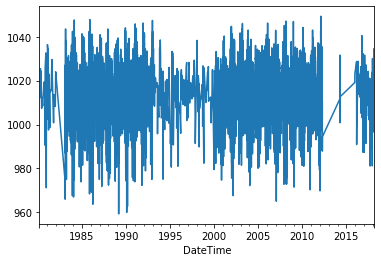

In [19]:
df["Esbjerg"]["Pressure"].plot()

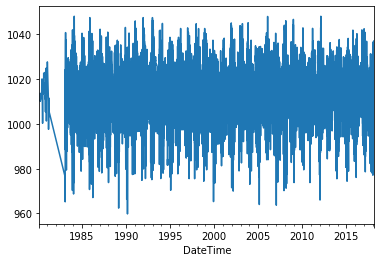

In [20]:
df["Roskilde"]["Pressure"].plot()

In [21]:
df.values.shape

(333109, 20)

In [22]:
df.drop(('Esbjerg', 'Pressure'), axis=1, inplace=True)
df.drop(('Roskilde', 'Pressure'), axis=1, inplace=True)

In [23]:
df.values.shape

(333109, 18)

In [24]:
df.head(1)

Aalborg                                Aarhus           \
                       Temp     Pressure WindSpeed WindDir   Temp Pressure   
DateTime                                                                     
1980-03-01 11:00:00     5.0  1007.766667      10.2   280.0    5.0   1008.3   

                                        Esbjerg                       Odense  \
                    WindSpeed WindDir      Temp  WindSpeed WindDir      Temp   
DateTime                                                                       
1980-03-01 11:00:00      15.4   290.0  6.083333  12.383333   310.0  6.142857   

                                                    Roskilde             \
                        Pressure  WindSpeed WindDir     Temp  WindSpeed   
DateTime                                                                  
1980-03-01 11:00:00  1011.066667  12.585714   290.0      5.0  11.466667   

                             
                    WindDir  
DateTime                     
1980-03-01 11:00:00   280.0

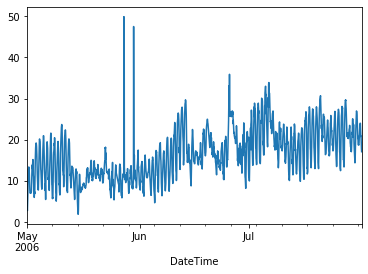

In [25]:
df['Odense']['Temp']['2006-05':'2006-07'].plot()

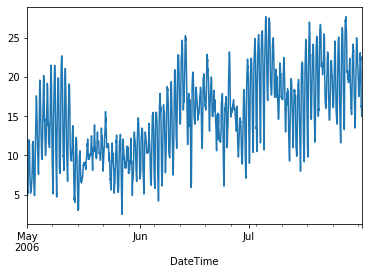

In [26]:
df['Aarhus']['Temp']['2006-05':'2006-07'].plot()

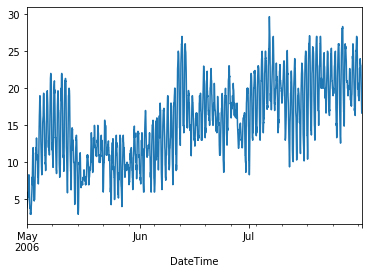

In [27]:
df['Roskilde']['Temp']['2006-05':'2006-07'].plot()

In [28]:
df["various", "day"] = df.index.dayofyear
df["various", "hour"] = df.index.hour

In [29]:
df.head()

Aalborg                                    Aarhus  \
                         Temp     Pressure WindSpeed     WindDir   Temp   
DateTime                                                                  
1980-03-01 11:00:00  5.000000  1007.766667      10.2  280.000000    5.0   
1980-03-01 12:00:00  5.000000  1008.000000      10.3  290.000000    5.0   
1980-03-01 13:00:00  5.000000  1008.066667       9.7  290.000000    5.0   
1980-03-01 14:00:00  4.333333  1008.133333      11.1  283.333333    5.0   
1980-03-01 15:00:00  4.000000  1008.200000      11.3  280.000000    5.0   

                                                     Esbjerg             \
                        Pressure WindSpeed WindDir      Temp  WindSpeed   
DateTime                                                                  
1980-03-01 11:00:00  1008.300000      15.4   290.0  6.083333  12.383333   
1980-03-01 12:00:00  1008.600000      13.4   280.0  6.583333  12.883333   
1980-03-01 13:00:00  1008.433333      15.4   280.0  6.888889  13.244444   
1980-03-01 14:00:00  1008.266667      14.9   300.0  6.222222  12.911111   
1980-03-01 15:00:00  1008.100000      17.0   290.0  5.555556  12.577778   

                                   Odense                                  \
                        WindDir      Temp     Pressure  WindSpeed WindDir   
DateTime                                                                    
1980-03-01 11:00:00  310.000000  6.142857  1011.066667  12.585714   290.0   
1980-03-01 12:00:00  310.000000  7.000000  1011.200000  11.300000   290.0   
1980-03-01 13:00:00  309.444444  7.000000  1011.300000  12.118182   290.0   
1980-03-01 14:00:00  306.111111  6.857143  1011.400000  12.742857   290.0   
1980-03-01 15:00:00  302.777778  6.000000  1011.500000  12.400000   290.0   

                     Roskilde                        various       
                         Temp  WindSpeed     WindDir     day hour  
DateTime                                                           
1980-03-01 11:00:00  5.000000  11.466667  280.000000      61   11  
1980-03-01 12:00:00  5.000000  12.466667  280.000000      61   12  
1980-03-01 13:00:00  5.166667  13.133333  278.333333      61   13  
1980-03-01 14:00:00  5.833333  12.300000  270.000000      61   14  
1980-03-01 15:00:00  4.833333  12.300000  270.000000      61   15

In [30]:
target_city = "Odense"

In [34]:
target_names = ["Temp", "Pressure", "WindSpeed"]

In [32]:
shift_days = 1
shift_steps = shift_days * 24

In [35]:
df_targets = df[target_city][target_names].shift(-shift_steps)

In [36]:
df[target_city][target_names].shift(shift_steps + 5)

,Temp,Pressure,WindSpeed
DateTime,,,
1980-03-01 11:00:00,NaN,NaN,NaN
1980-03-01 12:00:00,NaN,NaN,NaN
1980-03-01 13:00:00,NaN,NaN,NaN
1980-03-01 14:00:00,NaN,NaN,NaN
1980-03-01 15:00:00,NaN,NaN,NaN
...,...,...,...
2018-03-01 19:00:00,-4.7,1033.0,10.8
2018-03-01 20:00:00,-5.2,1032.8,10.3
2018-03-01 21:00:00,-5.3,1032.7,10.8


In [37]:
df_targets.head()

,Temp,Pressure,WindSpeed
DateTime,,,
1980-03-01 11:00:00,2.000000,1005.833333,6.828571
1980-03-01 12:00:00,2.000000,1005.200000,8.200000
1980-03-01 13:00:00,0.166667,1004.766667,9.216667
1980-03-01 14:00:00,1.000000,1004.333333,11.885714
1980-03-01 15:00:00,1.000000,1003.900000,12.400000


In [38]:
df_targets.tail()

,Temp,Pressure,WindSpeed
DateTime,,,
2018-03-01 19:00:00,NaN,NaN,NaN
2018-03-01 20:00:00,NaN,NaN,NaN
2018-03-01 21:00:00,NaN,NaN,NaN
2018-03-01 22:00:00,NaN,NaN,NaN
2018-03-01 23:00:00,NaN,NaN,NaN


In [39]:
x_data = df.values[0:-shift_steps]

In [40]:
print(type(x_data))

<class 'numpy.ndarray'>


In [41]:
x_data.shape

(333085, 20)

In [42]:
y_data = df_targets.values[:-shift_steps]

In [43]:
y_data.shape

(333085, 3)

In [44]:
num_data = len(x_data)

In [45]:
num_data

333085

In [46]:
train_split = 0.9

In [47]:
num_train = int(train_split * num_data)

In [48]:
num_train

299776

In [49]:
num_test = num_data - num_train

In [50]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

333085

In [51]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

333085

In [52]:
num_x_signals = x_data.shape[1]
print(num_x_signals)

20


In [53]:
num_y_signals = y_data.shape[1]
print(num_y_signals)

3


In [54]:
print("Min: ", np.min(x_train))
print("Max: ", np.max(x_train))

Min:  -27.0
Max:  1050.8


In [55]:
x_scaler = MinMaxScaler()

In [56]:
x_train_scaled = x_scaler.fit_transform(x_train)

In [57]:
print("Min: ", np.min(x_train_scaled))
print("Max: ", np.max(x_train_scaled))

Min:  0.0
Max:  1.0000000000000002


In [58]:
x_test_scaled = x_scaler.transform(x_test)

In [59]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [60]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(299776, 20)
(299776, 3)


In [61]:
def batch_generator(batch_size, sequence_length):
    while True:
        # Allocate a new array for the batch of input-signals
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)
        
        # Allocate a new array for the batch of output-signals
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)
        
        # fill the batch with random sequences of data
        for i in range(batch_size):
            idx = np.random.randint(num_train - sequence_length)
            
            
            # copy the sequences of data starting at this index
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
            
        yield (x_batch, y_batch)

In [62]:
batch_size = 256

In [63]:
sequence_length = 24 * 7 * 8
print(sequence_length)

1344


In [64]:
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [65]:
x_batch, y_batch = next(generator)

In [66]:
x_batch, y_batch

(array([[[0.6987 , 0.7554 , 0.0456 , ..., 0.2285 , 0.5015 , 0.1305 ],
         [0.717  , 0.76   , 0.0456 , ..., 0.238  , 0.5015 , 0.174  ],
         [0.7407 , 0.764  , 0.06384, ..., 0.2524 , 0.5015 , 0.2174 ],
         ...,
         [0.665  , 0.724  , 0.10944, ..., 0.7715 , 0.655  , 0.     ],
         [0.645  , 0.7266 , 0.09424, ..., 0.7715 , 0.655  , 0.0435 ],
         [0.6274 , 0.7285 , 0.09424, ..., 0.7764 , 0.655  , 0.087  ]],
 
        [[0.5913 , 0.6265 , 0.157  , ..., 0.785  , 0.2439 , 0.5654 ],
         [0.5884 , 0.6284 , 0.1398 , ..., 0.793  , 0.2439 , 0.609  ],
         [0.577  , 0.63   , 0.1398 , ..., 0.8286 , 0.2439 , 0.6523 ],
         ...,
         [0.735  , 0.7207 , 0.155  , ..., 0.347  , 0.3972 , 0.4348 ],
         [0.729  , 0.72   , 0.1398 , ..., 0.3713 , 0.3972 , 0.4783 ],
         [0.7456 , 0.7197 , 0.12463, ..., 0.2856 , 0.3972 , 0.522  ]],
 
        [[0.639  , 0.695  , 0.05167, ..., 0.2952 , 0.786  , 0.826  ],
         [0.6436 , 0.695  , 0.0812 , ..., 0.355  , 0.786

In [67]:
print(x_batch.shape)
print(y_batch.shape)

(256, 1344, 20)
(256, 1344, 3)


In [68]:
batch = 0
signal = 0
seq = x_batch[batch, : , signal]

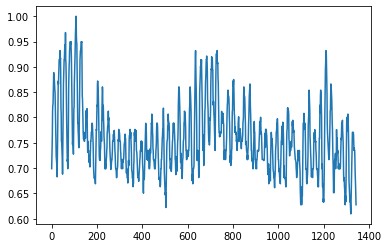

In [69]:
plt.plot(seq)

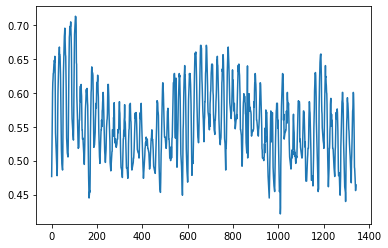

In [70]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [71]:
validation_data = (np.expand_dims(x_test_scaled, axis=0), np.expand_dims(y_test_scaled, axis=0))

### create the rnn network

In [73]:
model = Sequential()
model.add(GRU(units=512, return_sequences=True, input_shape=(None, num_x_signals,)))
model.add(Dense(num_y_signals, activation='sigmoid'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [74]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform
    
    # maybe use lower init ranges
    init = RandomUniform(minval=-0.05, maxval=0.05)
    
    model.add(Dense(num_y_signals, activation='linear', kernel_initializer=init))

In [75]:
warmup_steps = 50

In [77]:
def loss_mse_warmup(y_true, y_pred):
    y_true_slice = y_true[:, warmup_steps:, :]  
    y_pred_slice = y_pred[:, warmup_steps:, :]
    
    loss = tf.losses.mean_squared_error(labels=y_true_slice, predictions=y_pred_slice)
    
    loss_mean = tf.reduce_mean(loss)
    
    return loss_mean
    

In [78]:
optimizer = RMSprop(lr=1e-3)

In [79]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [80]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         818688    
_________________________________________________________________
dense (Dense)                (None, None, 3)           1539      
Total params: 820,227
Trainable params: 820,227
Non-trainable params: 0
_________________________________________________________________


In [81]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint, 
                                      monitor='val_loss',
                                      verbose=1, save_weights_only=True, save_best_only=True)

In [82]:
callback_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [83]:
callback_tensorboard = TensorBoard(log_dir='./23_logs', histogram_freq=0, write_graph=False)

In [84]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=1e-4, patience=0, verbose=1)

In [85]:
callbacks = [callback_early_stopping, callback_checkpoint, callback_tensorboard, callback_reduce_lr]

In [87]:
%%time

# model.fit_generator(generator=generator,
#                     epochs=20, steps_per_epoch=100,
#                     validation_data=validation_data,
#                     callbacks=callbacks)

model.fit_generator(generator=generator,
                    epochs=2, steps_per_epoch=2,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/2
1/2 [==============>...............] - ETA: 31s - loss: 0.0062
Epoch 00001: val_loss improved from inf to 0.00622, saving model to 23_checkpoint.keras
2/2 [==============================] - 252s 126s/step - loss: 0.0076 - val_loss: 0.0062
Epoch 2/2
1/2 [==============>...............] - ETA: 29s - loss: 0.0070
Epoch 00002: val_loss did not improve from 0.00622

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2/2 [==============================] - 241s 120s/step - loss: 0.0073 - val_loss: 0.0070
CPU times: user 20min 26s, sys: 14min 13s, total: 34min 39s
Wall time: 8min 12s


In [88]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [89]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0), y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 27s 27s/sample - loss: 0.0062


In [90]:
print("loss (test-set):", result)

loss (test-set): 0.006224107928574085


In [91]:
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

In [99]:
def plot_comparison(start_idx, length=100, train=True):
    if train:
        x = x_train_scaled
        y_true = y_train
    else:
        x = x_test_scaled
        y_true = y_test
        
    # end idx for the sequences
    end_idx = start_idx + length
    
    # select the sequences from the given start idx and of the given length
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # inout signals for the model
    x = np.expand_dims(x, axis=0)
    
    # use the model to predict the output signals
    y_pred = model.predict(x)
    
    # the output of the model is between 0 and 1
    # do an inverse map to get it back to the scale
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    for signal in range(len(target_names)):
        signal_pred = y_pred_rescaled[:, signal]
        signal_true = y_true[:, signal]
        
        plt.figure(figsize=(15, 5))
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

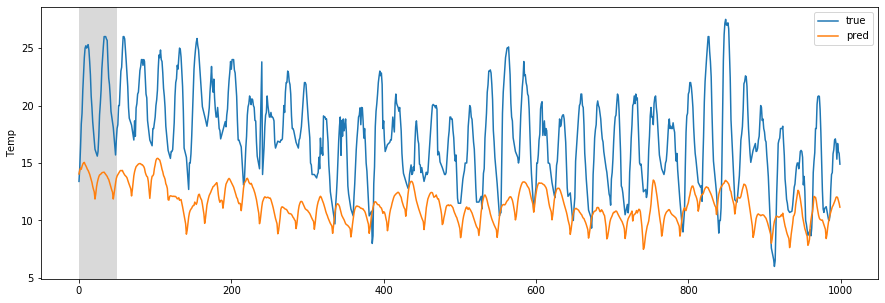

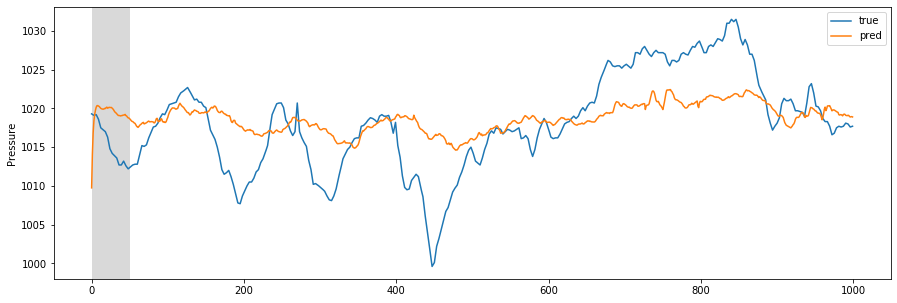

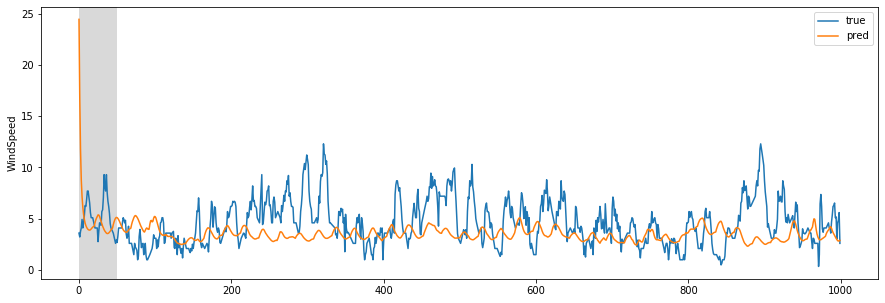

In [100]:
plot_comparison(start_idx=100000, length=1000, train=True)

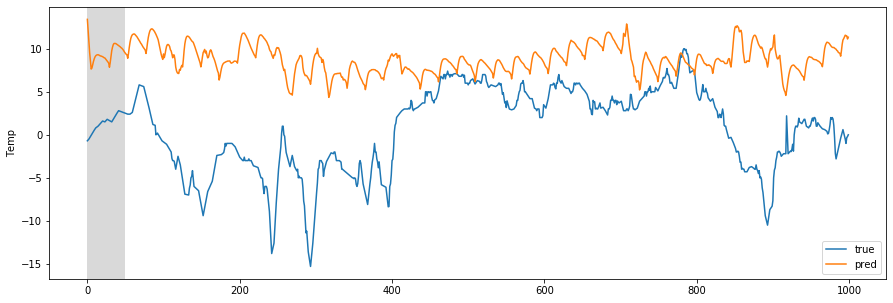

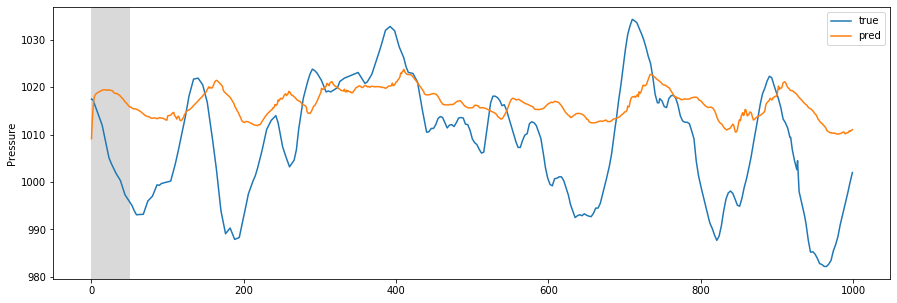

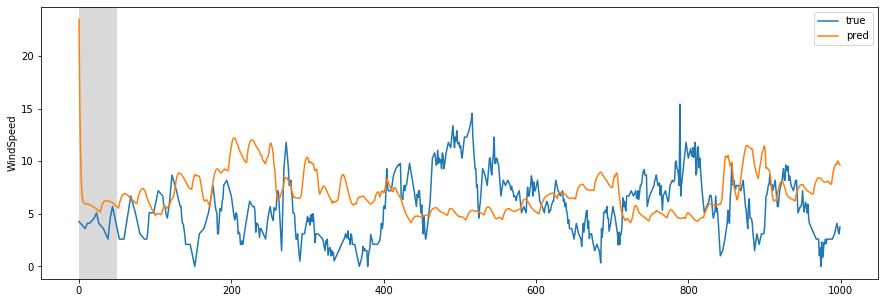

In [101]:
plot_comparison(start_idx=200000, length=1000, train=True)

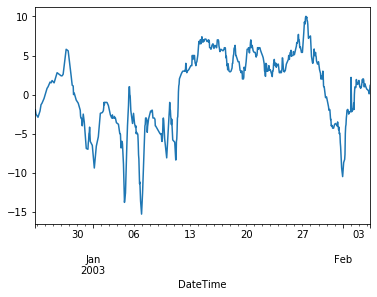

In [97]:
df['Odense']['Temp'][200000:200000+1000].plot()

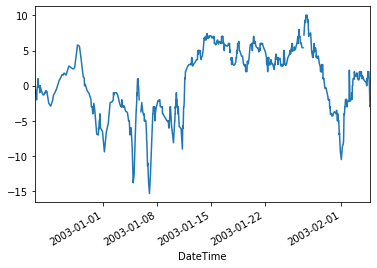

In [98]:
df_org = weather.load_original_data()
df_org.xs('Odense')['Temp']['2002-12-23':'2003-02-04'].plot()

The code is pretty much what is in the tutorial. But the number of training has not been there as training done on the laptop. maybe can be trained on google colab to make better training. then might be able to see what will happen with the whole training